In [ ]:
"""
银行客户流失分类问题：
标签分类不平衡
深层全连接网络
"""
import numpy as np  # 导入NumPy数学工具箱
import pandas as pd  # 导入Pandas数据处理工具箱
import matplotlib.pyplot as plt  # 导入matplotlib画图工具箱
import seaborn as sns  # 导入seaborn画图工具箱
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler  # 导入特征缩放器
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
df_bank = pd.read_csv('/content/drive/MyDrive/DL/data_test/handson_book/BankCustomer.csv')
df_bank.head()

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited
0,Kan Jian,Female,40,Beijing,9,2,0,1,516,6360.66,0.0000,0
1,Xue Baochai,Male,69,Beijing,6,2,0,1,682,28605.00,0.0000,0
2,Mao Xi,Female,32,Beijing,9,1,1,1,803,10378.09,236311.0932,1
3,Zheng Nengliang,Female,37,Tianjin,0,2,1,1,778,25564.01,129909.8079,1
4,Zhi Fen,Male,55,Tianjin,4,3,1,0,547,3235.61,136976.1948,1


In [ ]:
# 显示不同特征的分布情况
features = ['City', 'Gender', 'Age', 'Tenure',
            'ProductsNo', 'HasCard', 'ActiveMember', 'Exited']

In [ ]:
# --------------------------数据预处理--------------------------#
# 把二元类别文本数字化
df_bank['Gender'].replace("Female", 0, inplace=True)
df_bank['Gender'].replace("Male", 1, inplace=True)
print("Gender unique values", df_bank['Gender'].unique())  # Gender unique values [0 1]

Gender unique values [0 1]


In [ ]:
# 把多元类别转换成多个二元哑变量，然后贴回原始数据集
d_city = pd.get_dummies(df_bank['City'], prefix="City")
df_bank = [df_bank, d_city]
df_bank = pd.concat(df_bank, axis=1)

In [ ]:
y = df_bank['Exited']
X = df_bank.drop(['Name', 'Exited', 'City'], axis=1)
X.head()

,Gender,Age,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,City_Beijing,City_Shanghai,City_Tianjin
0,0,40,9,2,0,1,516,6360.66,0.0000,1,0,0
1,1,69,6,2,0,1,682,28605.00,0.0000,1,0,0
2,0,32,9,1,1,1,803,10378.09,236311.0932,1,0,0
3,0,37,0,2,1,1,778,25564.01,129909.8079,0,0,1
4,1,55,4,3,1,0,547,3235.61,136976.1948,0,0,1


In [ ]:
# --------------------------拆分数据集--------------------------#
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0)

In [ ]:
# --------------------------特征缩放--------------------------#
sc = StandardScaler()  # 特征缩放器
X_train = sc.fit_transform(X_train)  # 拟合并应用于训练集
X_test = sc.transform(X_test)  # 训练集结果应用于测试集

In [ ]:
# 构建模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'),  # 输入层
    tf.keras.layers.Dense(units=24, activation='relu'),  # 隐层
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=48, activation='relu'),  # 隐层
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=96, activation='relu'),  # 隐层
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=192, activation='relu'),  # 隐层
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # 输出层，二分类
])

In [ ]:
# 编译模型
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-7)
model_ckpt = ModelCheckpoint(filepath='./ckpt/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='max')
tensorboard_callback = TensorBoard("logs")
callbacks = [early_stop, reduce_lr, model_ckpt, tensorboard_callback]  # 设定回调

In [ ]:
history = model.fit(X_train, y_train, # 指定训练集
                  epochs=100,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_data=(X_test, y_test),  #指定验证集,这里为了简化模型，直接用测试集数据进行验证
                  callbacks = callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/125 [===========================>..] - ETA: 0s - loss: 0.5474 - accuracy: 0.7824
Epoch 1: val_loss improved from -inf to 0.51583, saving model to ./ckpt/model.h5
125/125 [==============================] - 6s 9ms/step - loss: 0.5476 - accuracy: 0.7824 - val_loss: 0.5158 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 2/100
 26/125 [=====>........................] - ETA: 0s - loss: 0.5169 - accuracy: 0.7861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


117/125 [===========================>..] - ETA: 0s - loss: 0.4971 - accuracy: 0.7987
Epoch 2: val_loss did not improve from 0.51583
125/125 [==============================] - 1s 5ms/step - loss: 0.4987 - accuracy: 0.7976 - val_loss: 0.5132 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 3/100
117/125 [===========================>..] - ETA: 0s - loss: 0.4866 - accuracy: 0.7962
Epoch 3: val_loss did not improve from 0.51583
125/125 [==============================] - 1s 5ms/step - loss: 0.4837 - accuracy: 0.7975 - val_loss: 0.4917 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 4/100
124/125 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.7975
Epoch 4: val_loss did not improve from 0.51583
125/125 [==============================] - 1s 7ms/step - loss: 0.4700 - accuracy: 0.7975 - val_loss: 0.4878 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 5/100
122/125 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.7989
Epoch 5: val_loss did not improve from 0.51583
125/

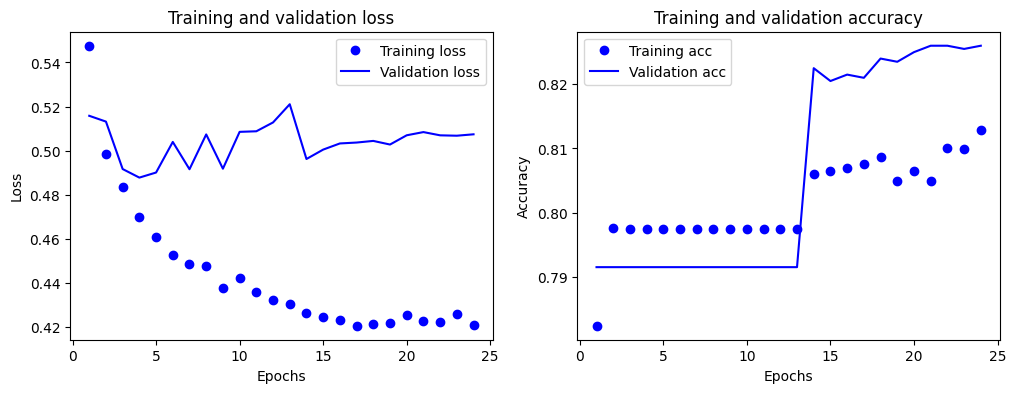

In [ ]:
def show_history(history):  # 显示训练过程中的学习曲线
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


show_history(history)  # 调用这个函数，并将神经网络训练历史数据作为参数输入

In [ ]:
# 预测
y_pred = model.predict(X_test, batch_size=10)  # 预测测试集的标签
y_pred = np.round(y_pred)  # 四舍五入，将分类概率值转换成0/1整数值

200/200 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import classification_report
def show_report(X_test, y_test, y_pred):  # 定义一个函数显示分类报告
    if y_test.shape != (2000, 1):
        y_test = y_test.values  # 把Panda series转换成Numpy array
        y_test = y_test.reshape((len(y_test), 1))  # 转换成与y_pred相同的形状
    print(classification_report(y_test, y_pred, labels=[0, 1]))  # 调用分类报告

In [ ]:
show_report(X_test, y_test, y_pred)

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1583
           1       0.00      0.00      0.00       417

    accuracy                           0.79      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.79      0.70      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
